# 프로젝트 개요
- 프로젝트 명 : 비제이들의 특정기간 동안의(월간) 별풍선 수익 집계 툴 제작
- 계기 : 한 비제이가 약 30명의 수익 합계 데이터를 일일히 수작업으로 하는 모습을 보고 자동화 툴을 제작하고 싶어짐
- 인원 : 안응민 1명
- 기간 : 2024.03.09 ~

# 패키지 설치

In [ ]:
!pip install pytesseract
!pip install opencv-python
!pip install jupyter_contrib_nbextensions && jupyter contrib nbextension install
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install BeautifulSoup4
!pip install pyautogui
!pip install clipboard
!pip install selenium --trusted-host pypi.org --trusted-host files.pythonhosted.org
!pip install webdriver-manager  --trusted-host pypi.org --trusted-host files.pythonhosted.org
!pip install keyboard
!pip install pymysql
!pip install sqlalchemy
!pip install mariadb
!pip install mysqlclient
!pip install selenium --upgrade
!pip install --upgrade webdriver-manager
!pip install google-play-scraper
!pip install konlpy
!pip install tensorflow
!pip install nltk
!pip install geopy 
!pip install folium

# 패키지 import

In [1]:
# 필요패키지 import
import time
from tqdm.notebook import tqdm
import json
import urllib
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyautogui
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import clipboard
import pyperclip
import dataframe_image
from google_play_scraper import Sort, app, reviews_all
import nltk
import folium
from selenium.webdriver.common.action_chains import ActionChains

# konlpy
from konlpy.tag import Okt
okt=Okt()

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from geopy.geocoders import Nominatim
geo_local = Nominatim(user_agent='South Korea')

# 셀레니움 import
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support import expected_conditions as EC

# webdriver 자동설정
def set_chrome_driver():
    chrome_options = webdriver.ChromeOptions()
    driver = webdriver.Chrome(service=Service(), options=chrome_options)
    return driver
driver=set_chrome_driver()
driver.close()


import time
import warnings
warnings.filterwarnings(action='ignore')
from bs4 import BeautifulSoup

from pytesseract import Output
import pytesseract
import cv2

import urllib.request
from PIL import Image
class AppURLopener(urllib.request.FancyURLopener):
    version = "Mozilla/5.0"
    
urllib._urlopener = AppURLopener()

import os
import keyboard
import getpass
from sqlalchemy import create_engine

def driverxpath(x):
    return driver.find_element(By.XPATH, x)

def drivercss(x):
    return driver.find_element(By.CSS_SELECTOR, x)

def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
        else:
            print(f'{directory} 폴더가 이미 존재합니다.')
    except OSError:
        print ('Error: Creating directory. ' +  directory)

In [15]:
os.listdir()

['.ipynb_checkpoints',
 '2024-02-08_2024-03-07_poong_sum.csv',
 'bj_list.csv',
 'February_poong_sum.csv',
 'poong_result.png',
 'sooni.csv',
 'sumpoong.ipynb']

# 별풍선 수익 집계 툴 제작

## 2024.03.09 버전

In [7]:
bj_df=pd.read_csv('./sooni.csv', encoding='cp949')
bj_name_list=bj_df['name'].to_list()
bj_id_list=bj_df['id'].to_list()
bj_department_list=bj_df['department'].to_list()


start_date=input('시작 날짜를 입력하세요(2024-2-8 형식) : ')
end_date=input('마감 날짜를 입력하세요(2024-3-7 형식) : ')

start_date=datetime.strptime(start_date, "%Y-%m-%d")
end_date=datetime.strptime(end_date, "%Y-%m-%d")

td=end_date - start_date
ideal_number=td.days+1

str_start_date=datetime.strftime(start_date, '%Y-%m-%d')
str_end_date=datetime.strftime(end_date, '%Y-%m-%d')

poong_df_list=[]
sum_poong_df_list=[]

for bj in tqdm(bj_id_list):
    driver=set_chrome_driver()
    url=f'https://poong.today/bj/{bj}'
    driver.get(url)
    driver.maximize_window()
    driver.refresh()
    time.sleep(1)

    driverxpath('//*[@id="app"]/div[4]/div[2]/div[4]/div').click()
    time.sleep(5)
    canvas=driverxpath('//*[@id="details_chart"]/div[1]/canvas')

    a=-60
    date_list=[]
    poong_list=[]

    for i in range(100):
        a+=10
        try:
            actions = ActionChains(driver)
            actions.move_to_element(canvas).perform()
            actions.move_by_offset(a, 50).perform()
            x=driverxpath('//*[@id="details_chart"]/div[2]').text
            k=datetime.strptime(x.split('\n')[0], "%Y-%m-%d")
            d=x.split('\n')[1]
            d=int(d.replace(',',''))

        except:
            break

        if k >= start_date and k <= end_date:
            date_list.append(k)
            poong_list.append(d)
        elif k >= end_date:
            driver.close()
            break

    poong_data={'date':date_list
             , 'poong':poong_list}

    poong_df=pd.DataFrame(poong_data)
    poong_df=poong_df.drop_duplicates()
    poong_df=poong_df.reset_index(drop=True)
    poong_df_list.append(poong_df)    
    sum_poong_df={'id':bj
                  ,'number':len(poong_df)
                  ,'sum':poong_df['poong'].sum()}
    sum_poong_df=pd.DataFrame([sum_poong_df])
    sum_poong_df_list.append(sum_poong_df)
    
bj_poong_sum=pd.concat(sum_poong_df_list).reset_index(drop=True)
poong_result=pd.merge(bj_df,bj_poong_sum)

poong_result.to_csv(f'./{str_start_date}_{str_end_date}_poong_sum.csv', index=False, encoding='cp949')
poong_result

시작 날짜를 입력하세요(2024-2-8 형식) : 2024-2-8
마감 날짜를 입력하세요(2024-3-7 형식) : 2024-3-7


  0%|          | 0/28 [00:00<?, ?it/s]

,name,id,department,number,sum
0,[NS남순],wnnw,기획,20,3442195
1,겸둥이,jyurim99,뮤직,20,492365
2,♥져리♥,tlswlgus95,뮤직,20,48028
3,안예슬띠,indy1028,뮤직,20,268266
4,배그나,goodb99,뮤직,20,213853
5,빡다혜♥,dkjfke,뮤직,20,78676
6,미캣♥,jieujieun11,뮤직,20,122042
7,믿고듣는다니,dani67,뮤직,20,213221
8,진솔[美],ooo9330,뮤직,20,186123
9,권도연♪,tpqhrdl,뮤직,20,94621


- 9일치 데이터 누락 및 18분 걸림
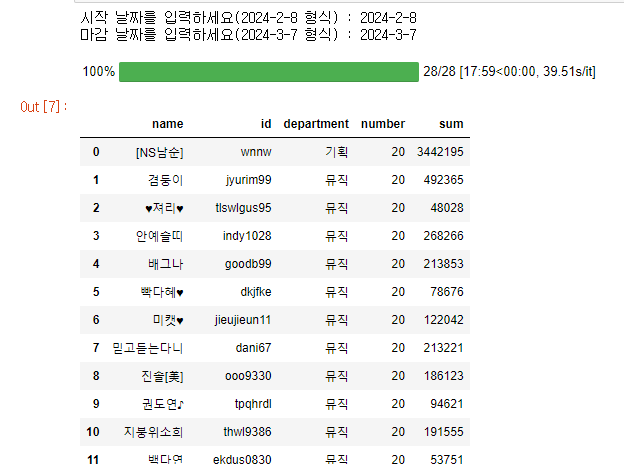

## 2024.03.12 버전

In [9]:
start_date=input('시작 날짜를 입력하세요. 예)2024-2-8 : ')
end_date=input('종료 날짜를 입력하세요. 예)2024-3-7 : ')

s_date=datetime.strptime(start_date, '%Y-%m-%d').date()
e_date=datetime.strptime(end_date, '%Y-%m-%d').date()
month=datetime.strftime(s_date,'%B')

bj_df=pd.read_csv('./sooni.csv', encoding='cp949')
bj_name_list=bj_df['name'].to_list()
bj_id_list=bj_df['id'].to_list()
bj_department_list=bj_df['department'].to_list()

poong_df_list=[]

for bj in tqdm(bj_id_list):
    url=f'https://poong.today/bj/{bj}'
    driver=set_chrome_driver()
    driver.maximize_window()
    driver.get(url)
    driverxpath('//*[@id="app"]/div[4]/div[2]/div[4]/div').click()
    time.sleep(3)
    actions = ActionChains(driver)
    canvas=driverxpath('//*[@id="details_chart"]/div[1]/canvas')
    
    date_list=[]
    poong_list=[]

    
    a=-360
    for i in range(100):
        a+=15
        if a<=420:
            actions.move_to_element_with_offset(canvas,a,0).click() # x범위 : -360 ~ 420
            actions.perform()
            x=driverxpath('//*[@id="details_chart"]/div[2]').text
            date=datetime.strptime(x.split('\n')[0], '%Y-%m-%d').date()
            poong=int(x.split('\n')[1].replace(',',''))
            
            if date >= s_date and date <= e_date:
                date_list.append(date)
                poong_list.append(poong)
            
    poong_df={'date':date_list
                     ,'poong':poong_list}

    driver.close()
    
    poong_df=pd.DataFrame(poong_df)
    poong_df=poong_df.drop_duplicates().reset_index(drop=True)
    poong_df_list.append(poong_df)

sum_poong_df={'name':bj_name_list
              ,'id':bj_id_list
              ,'department':bj_department_list
              , 'count' : [i['date'].count() for i in poong_df_list]
              ,'poong_sum':[i['poong'].sum() for i in poong_df_list]
             }

sum_poong_df=pd.DataFrame(sum_poong_df)
sum_poong_df.to_csv(f'./{month}_poong_sum.csv', index=False, encoding='cp949')
sum_poong_df

시작 날짜를 입력하세요. 예)2024-2-8 : 2024-2-8
종료 날짜를 입력하세요. 예)2024-3-7 : 2024-3-7


  0%|          | 0/28 [00:00<?, ?it/s]

,name,id,department,count,poong_sum
0,[NS남순],wnnw,기획,29,3624159
1,겸둥이,jyurim99,뮤직,29,673732
2,♥져리♥,tlswlgus95,뮤직,29,76934
3,안예슬띠,indy1028,뮤직,29,394061
4,배그나,goodb99,뮤직,29,309756
5,빡다혜♥,dkjfke,뮤직,29,150802
6,미캣♥,jieujieun11,뮤직,29,159399
7,믿고듣는다니,dani67,뮤직,29,282885
8,진솔[美],ooo9330,뮤직,29,334137
9,권도연♪,tpqhrdl,뮤직,29,199792


- 변경사항
> - 전체 그래프 조회를 위해 좌표값을 구함(-360 ~ 420)
> - 기존 조회 > 각각 데이터프레임화 > 아이디,합계를 구한 데이터프레임 병합(concat) > bj_df와 다시 병합 방식에서
>> 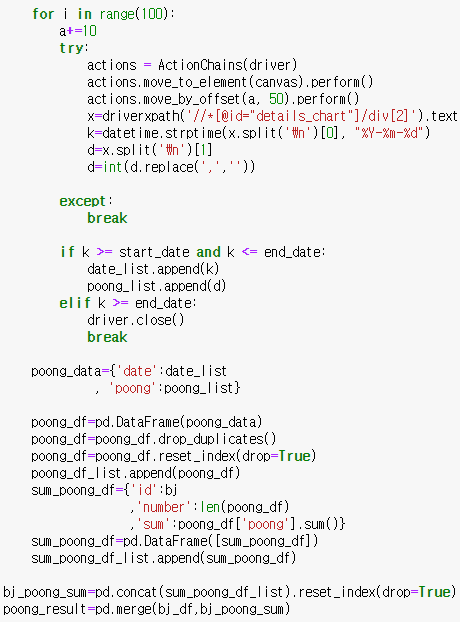
> - 조회 > 각각 데이터프레임화 > 데이터프레임 병합이 아닌 리스트 상태에서 한번에 데이터프레임화
>> 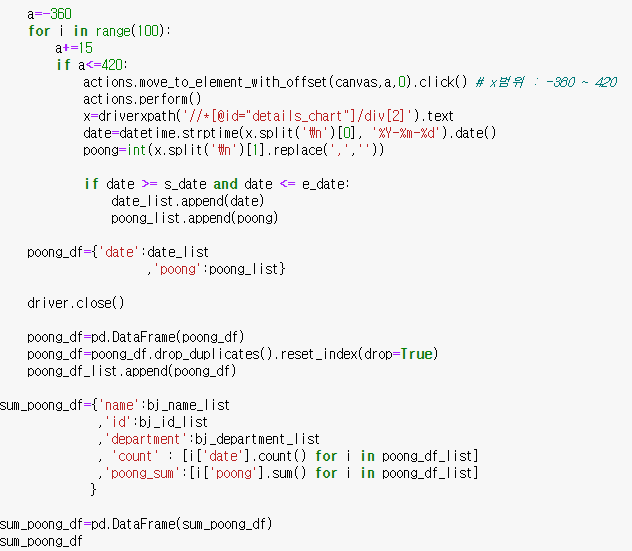

- 6분 감소된 12분 소요 누락된 데이터 없음
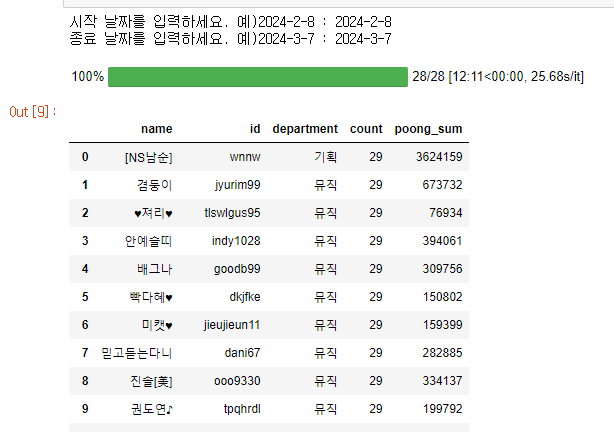

- 앞으로 계획 중인 개선 사항(2024.03.12)
> - 현재는 그래프 처음과 끝의 데이터를 수집 가능하지만 그게 꼭 구하고자 하는 범위에 해당하지 않을 수 있음
> - 따라서 조회 하고자 하는 범위에 해당하는지 확인하고 그렇지 않다면 마우스 휠 동작을 수행하여 그래프 범위 변경할 수 있도록 계획 중
> - 셀레니움을 활용한 방식으로는 기존 버전보다 6분 정도 단축되었지만 12분이라는 아직 긴 시간이 소요됨
> - 다른 사람이 엑셀 파워쿼리로 한 것처럼 보다 간편하고 빠르게 동작할 수 있는 방법을 찾을 것
> - 집계 결과를 엑셀 CSV로 저장하는 방식에서 MySQL에 저장하여 관리하도록 만들것